In [140]:
from art.attacks.evasion import SquareAttack
from art.estimators.classification import PyTorchClassifier

import torch
import numpy as np
from sklearn.datasets import fetch_openml
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import TensorDataset, DataLoader
from art.utils import load_mnist

In [141]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
y = y.astype(int)
print(X.shape)


(70000, 784)


In [142]:
X = X.reshape(X.shape[0], 1, 28, 28).astype(np.float32)
print(X.shape)
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

(70000, 1, 28, 28)


In [143]:
model = torch.load('mnistnet.pkl')

In [145]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [146]:
classifier = PyTorchClassifier(
    model=model,
    clip_values=(0, 255),
    loss=criterion,
    optimizer=optimizer,
    input_shape=(1, 28, 28),
    nb_classes=10
)

In [148]:
classifier.fit(X_train, y_train)

In [149]:
classifier.predict(X_train)

array([[ -1.2503978 , -21.410791  , -14.861835  , ..., -17.805141  ,
         -5.6852508 ,  -2.189767  ],
       [ 28.352997  , -37.209133  ,  -6.749797  , ..., -15.176989  ,
         -8.52273   ,  -6.4488273 ],
       [ -7.726456  ,   4.810106  ,  -7.888375  , ...,  -1.2868266 ,
         -6.0416512 ,  -4.2279105 ],
       ...,
       [  0.06489891, -23.426529  , -17.988892  , ..., -19.636305  ,
         -5.868191  ,  -0.92743576],
       [ -1.168447  ,  -4.9498625 ,  -4.894342  , ..., -24.317877  ,
         -0.8597841 , -13.592029  ],
       [ -9.598416  ,  -7.775364  ,  -7.8008914 , ..., -16.432966  ,
         18.466784  ,   1.437529  ]], dtype=float32)

In [166]:
from art.attacks.evasion import FastGradientMethod

# Step 6: Generate adversarial test examples
attack = SquareAttack(estimator=classifier, eps=70, max_iter=2)
X_test_adv = attack.generate(x=X_test)

SquareAttack - restarts:   0%|          | 0/1 [00:00<?, ?it/s]

SquareAttack - iterations:   0%|          | 0/2 [00:00<?, ?it/s]

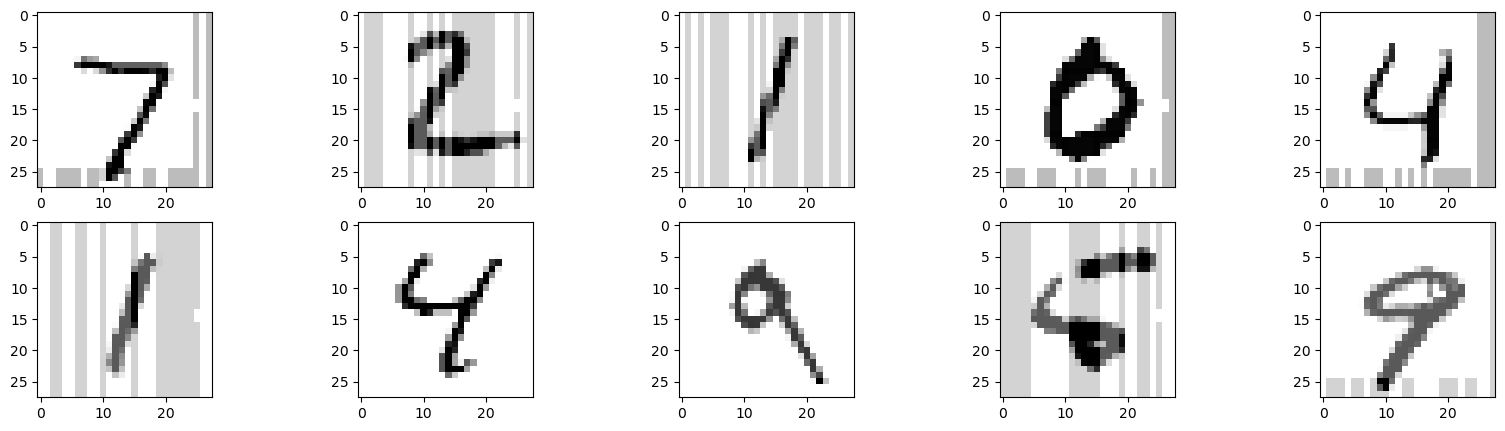

In [167]:
from matplotlib import pyplot as plt

plt.figure(figsize=(20, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_test_adv[i].reshape(28, 28), cmap='Greys')

In [169]:
# Step 7: Evaluate the ART classifier on adversarial test examples
test_dataset = TensorDataset(torch.from_numpy(np.array(X_test_adv)).float(),
                             torch.from_numpy(np.array(y_test)).long())
test_loader = DataLoader(test_dataset,
                         shuffle=True,
                         pin_memory=True,
                         num_workers=8,
                         drop_last=True,
                         batch_size=1)

correct = 0
total = 0
preds = []
for images, labels in test_loader:
    outputs = model(images)
    predicted = torch.argmax(outputs, dim=1)
    preds += predicted
    correct += (predicted == labels).sum().item()
    total += len(labels)
print(correct/total, correct, '/', total)

#8879

0.9487 9487 / 10000
0.9487 9487 / 10000


Обучение

In [170]:
NUM_EPOCHS = 6
BATCH_SIZE = 128
MOMENTUM = 0.9
LR_DECAY = 0.0005
LR_INIT = 0.01
IMAGE_DIM = 28
NUM_CLASSES = 10
DEVICE_IDS = [0, 1, 2, 3]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [171]:
def evaluate_model(nn_model):
    nn_model.eval()
    with torch.no_grad():
        correct_out = 0
        total_out = 0
        for pics, lbls in test_loader:
            out = nn_model(pics)
            pred = torch.argmax(out, dim=1)
            total_out += lbls.shape[0]
            correct_out += (pred == lbls).sum().item()

    loss_current = criterion(out, lbls)
    return correct_out / total_out, loss_current


In [172]:
X_train_adv = attack.generate(x=X_train)

SquareAttack - restarts:   0%|          | 0/1 [00:00<?, ?it/s]

SquareAttack - iterations:   0%|          | 0/2 [00:00<?, ?it/s]

In [173]:
train_dataset = TensorDataset(torch.from_numpy(np.array(X_train_adv)).float(),
                             torch.from_numpy(np.array(y_train)).long())
train_loader = DataLoader(train_dataset,
                         shuffle=True,
                         pin_memory=True,
                         num_workers=8,
                         drop_last=True,
                         batch_size=BATCH_SIZE)

In [174]:
optimizer = optim.Adam(params=model.parameters(), lr=0.0001)
print('Optimizer created')
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
print('LR Scheduler created')

Optimizer created
LR Scheduler created


In [175]:
import torch.nn.functional as F

accuracy_test_stat = []
accuracy_train_stat = []
loss_test_stat = []
loss_train_stat = []

# start training!!
print('Starting training...')
total_steps = 1
for epoch in range(NUM_EPOCHS):
    epoch_tr_accuracy = 0
    epoch_tr_loss = 0

    lr_scheduler.step()
    for imgs, classes in train_loader:
        imgs, classes = imgs.to(device), classes.to(device)

        # calculate the loss
        output = model(imgs)
        loss = F.cross_entropy(output, classes)

        # update the parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # log the information and add to tensorboard
        if total_steps % 200 == 0:
            with torch.no_grad():
                predictions = torch.argmax(output, dim=1)
                accuracy = (predictions == classes).sum() / len(predictions)

                epoch_tr_accuracy = accuracy.item()
                epoch_tr_loss = loss.item()

                print('Epoch: {} \tStep: {} \tLoss: {:.4f} \tAcc: {}'
                      .format(epoch + 1, total_steps, loss.item(), epoch_tr_accuracy))

        if total_steps % 400 == 0:
            a, l = evaluate_model(model)
            accuracy_train_stat.append(epoch_tr_accuracy)
            accuracy_test_stat.append(a)

            loss_train_stat.append(epoch_tr_loss)
            loss_test_stat.append(l)
        total_steps += 1

    # print(accuracy_test_stat, accuracy_train_stat, loss_test_stat, loss_train_stat)

Starting training...


/Users/megame/opt/anaconda3/envs/mnist_nn/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch: 1 	Step: 200 	Loss: 0.0066 	Acc: 1.0
Epoch: 1 	Step: 400 	Loss: 0.0042 	Acc: 1.0
Epoch: 2 	Step: 600 	Loss: 0.0883 	Acc: 0.984375
Epoch: 2 	Step: 800 	Loss: 0.0009 	Acc: 1.0
Epoch: 3 	Step: 1000 	Loss: 0.0010 	Acc: 1.0
Epoch: 3 	Step: 1200 	Loss: 0.0002 	Acc: 1.0
Epoch: 3 	Step: 1400 	Loss: 0.0062 	Acc: 1.0
Epoch: 4 	Step: 1600 	Loss: 0.0031 	Acc: 1.0
Epoch: 4 	Step: 1800 	Loss: 0.0012 	Acc: 1.0
Epoch: 5 	Step: 2000 	Loss: 0.0016 	Acc: 1.0
Epoch: 5 	Step: 2200 	Loss: 0.0256 	Acc: 0.9921875
Epoch: 6 	Step: 2400 	Loss: 0.0143 	Acc: 0.9921875
Epoch: 6 	Step: 2600 	Loss: 0.0011 	Acc: 1.0
Epoch: 6 	Step: 2800 	Loss: 0.0001 	Acc: 1.0


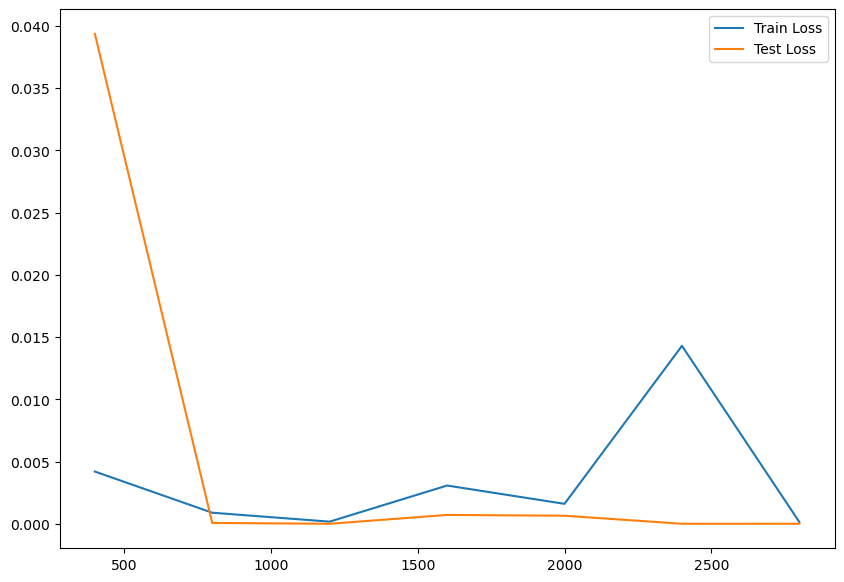

In [180]:
epochs = np.multiply(range(1, len(loss_train_stat) + 1), 400)
plt.figure(figsize=(10, 7))
plt.plot(epochs, loss_train_stat)
plt.plot(epochs, loss_test_stat)
plt.legend(["Train Loss", "Test Loss"])
plt.show()

[0.9775, 0.9857, 0.9865, 0.9862, 0.9825, 0.9821, 0.9825]


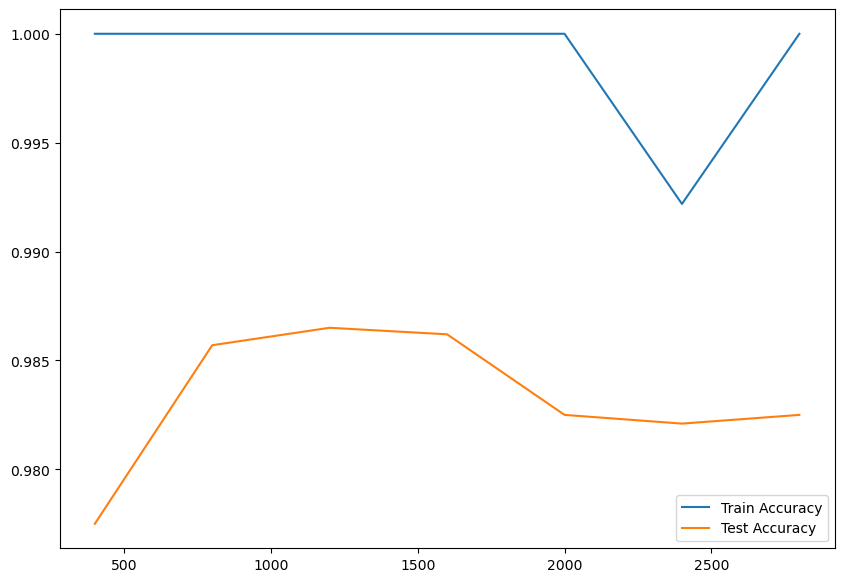

In [179]:
epochs = np.multiply(range(1, len(loss_train_stat) + 1), 400)
plt.figure(figsize=(10, 7))
print(accuracy_test_stat)
plt.plot(epochs, accuracy_train_stat)
plt.plot(epochs, accuracy_test_stat)
plt.legend(["Train Accuracy", "Test Accuracy"])
plt.show()

In [184]:
torch.save(classifier, 'mnistnet_square.pkl')

In [185]:
test_dataset = TensorDataset(torch.from_numpy(np.array(X_test)).float(),
                             torch.from_numpy(np.array(y_test)).long())
test_loader = DataLoader(test_dataset,
                         shuffle=True,
                         pin_memory=True,
                         num_workers=8,
                         drop_last=True,
                         batch_size=1)

correct = 0
total = 0
preds = []
for images, labels in test_loader:
    outputs = model(images)
    predicted = torch.argmax(outputs, dim=1)
    preds += predicted
    correct += (predicted == labels).sum().item()
    total += len(labels)
print(correct/total, correct, '/', total)


0.9847 9847 / 10000
